# Exercício 2.1
Utilizando o arquivo Usuarios-TempoMedioQuantidade.csv, que é uma amostra do tempo de utilização dos usuários em um determinado sistema, faça a clusterização utilizando k-means e DBSCAN.
* a) O que representam os clusters gerados?
* b) Qual é a melhor quantidade de Clusters?
* c) Qual é a melhor técnica (k-means ou DBSCAN) a ser utilizada nessa clusterização?

In [45]:
import pandas as pd
import numpy as np
import sklearn.metrics as sm
import matplotlib.pyplot as plt
import seaborn as sb
from itertools import cycle
from sklearn import datasets
from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

## Importando, analisando, entendendo e tratando os dados

In [46]:
# Importando os dados
data = pd.read_csv('bases/Usuarios-TempoMedioQuantidade.csv', encoding='cp850', sep=';') 
# O enconding foi escolhido na tentativa e erro (pode ainda estar errado)
data.head(10)

,NomeUsuario,Login,Email,NomeEquipe,Quantidade,TempoMedio
0,dadostab1,dadostab1,dadostab1@dadospesquisa.com.br,Equipe Dados Pesquisa,1498,0
1,axistab2,axistab2,axistab2@axiscriativa.com.br,Equipe Axis Criativa,461,75
2,axistab1,axistab1,axistab1@axiscriativa.com.br,Equipe Axis Criativa,445,7
3,planocdetab1,planocdetab1,planocdetab1@planocde.com.br,Equipe PlanoCDE,423,140
4,Usuario11,usuario11,usuario11@marketnnova.com,Equipe Marketnnova,351,22
5,Usuario5,usuario5,usuario5@marketnnova.com,Equipe Marketnnova,325,20
6,mbtab4,mbtab4,mbtab4@mb.com,Equipe Mil Sapatilhas,321,13
7,Usuario17,usuario17,usuario17@marketnnova.com,Equipe Marketnnova,278,10
8,Usuario1,usuario1,usuario1@marketnnova.com,Equipe Marketnnova,252,8
9,Usuario15,usuario15,usuario15@marketnnova.com,Equipe Marketnnova,236,14


In [47]:
# Analisando se existem valores faltantes
print(data.info(),'\n')

# Analisando a composição das variáveis numéricas
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   NomeUsuario  602 non-null    object
 1   Login        602 non-null    object
 2   Email        602 non-null    object
 3   NomeEquipe   602 non-null    object
 4   Quantidade   602 non-null    int64 
 5   TempoMedio   602 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 28.3+ KB
None 

        Quantidade   TempoMedio
count   602.000000   602.000000
mean     23.392027    52.023256
std      80.951470   177.753076
min       1.000000     0.000000
25%       1.000000    16.000000
50%       1.000000    25.000000
75%       3.000000    34.000000
max    1498.000000  1303.000000


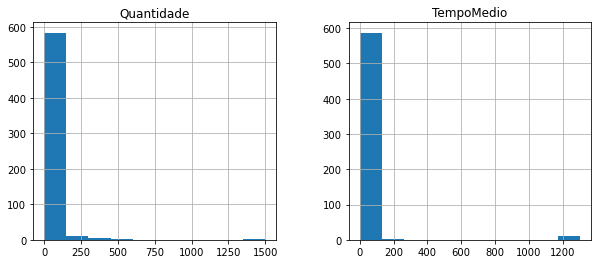

In [48]:
# Visualisando os dados
fig, ax = plt.subplots(figsize=(10,4))
data.hist(ax=ax);

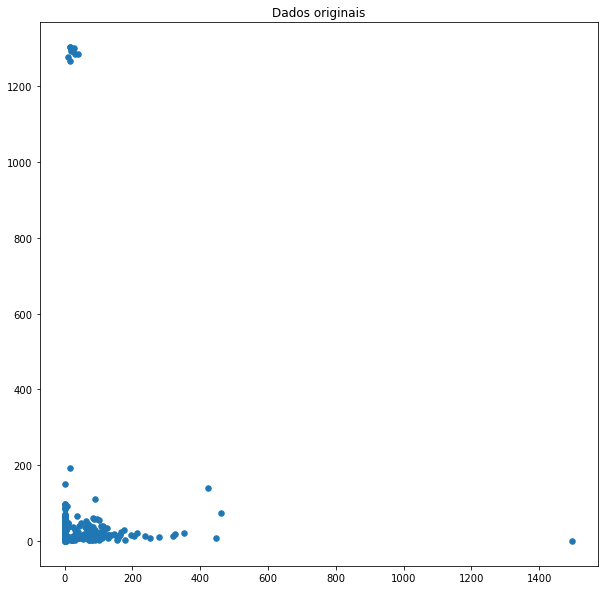

In [49]:
plt.figure(1, figsize=(10,10))
plt.scatter(data['Quantidade'], data['TempoMedio'], s=30)
plt.title('Dados originais')
plt.show()

In [50]:
# Normalizando os datos pelo método de minmax 
data_norm = pd.DataFrame(MinMaxScaler().fit_transform(data.loc[:,['Quantidade', 'TempoMedio']]), columns=['Quantidade', 'TempoMedio'])

## K-Means

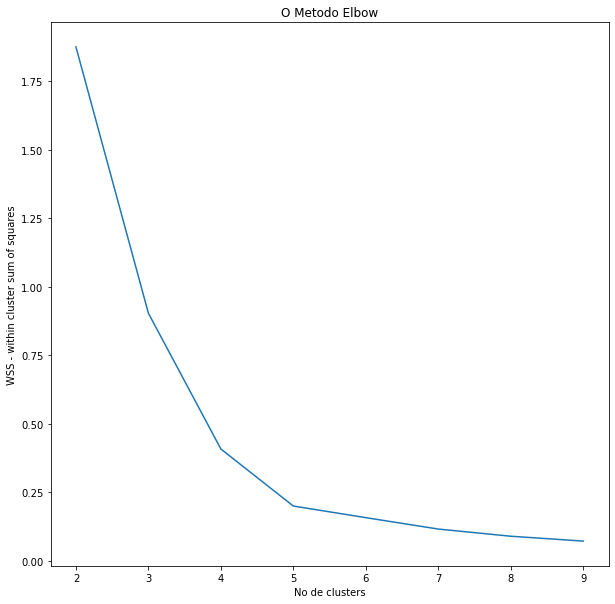

In [51]:
#Método Elbow para encontrar o melhor valor de k
inertias =[]
range_n_clusters = range(2, 10)
for i in range_n_clusters:
    kmeans = KMeans(n_clusters = i).fit(data_norm)
    #somatório dos erros quadráticos das instâncias de cada cluster
    inertias.append(kmeans.inertia_)

plt.figure(2, figsize=(10,10))
plt.plot(range_n_clusters, inertias)
plt.title('O Metodo Elbow')
plt.xlabel('No de clusters')
plt.ylabel('WSS - within cluster sum of squares')
plt.show()

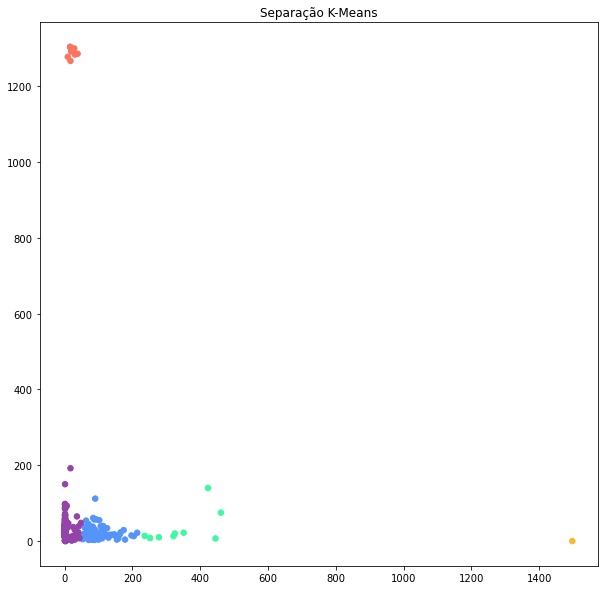

In [52]:
kdata = data_norm.copy()
# A partir do gráfico acima percebemos o que o númedo ideal de clusters está entre 4 e 5, escolhemos o 5 para nosso caso.
kmeans = KMeans(n_clusters = 5)
kmeans.fit(kdata[['Quantidade', 'TempoMedio']])

colormap=np.array(['#5595FA','#FA7461','#9443A8', '#FAB72F', '#3CFA9F'])

plt.figure(3, figsize=(10,10))
#plt.scatter(kdata['Quantidade'], kdata['TempoMedio'], c=colormap[kmeans.labels_], s=20)
plt.scatter(data['Quantidade'], data['TempoMedio'], c=colormap[kmeans.labels_], s=30)

plt.title('Separação K-Means')
plt.show()


## DBSCAN

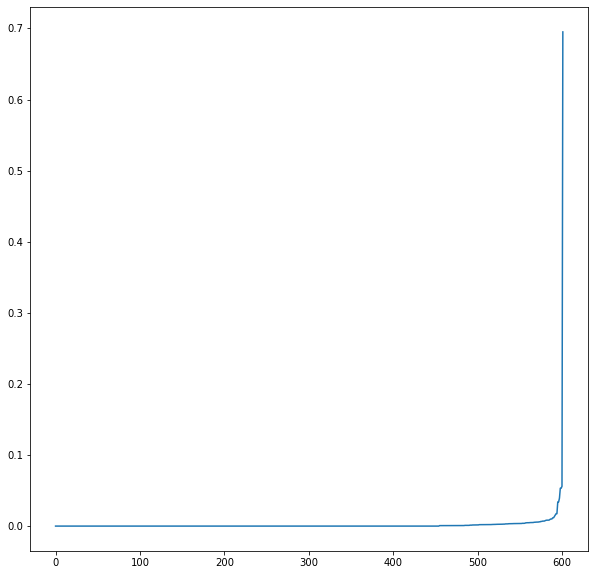

In [53]:
#Selecionando o melhor valor para o eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_norm)
distances, indices = nbrs.kneighbors(data_norm)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(4, figsize=(10,10))
plt.plot(distances);

Através deste método de não encotramos uma determinação explicita do valor de eps.

Por isso tentamos diversos valores selecionando o melhor Silhouette score utilisando grid search.

In [54]:
# Encontrando o melhor epsilon via silhouette_score
eps_grid = np.linspace(0.0001, 0.7999, num=20)
silhouette_scores = []
eps_best = eps_grid[0]
silhouette_score_max = -1
model_best = None
labels_best = None

In [55]:
X = data_norm.copy()

for eps in eps_grid:
    # Treinar o DBSCAN cluster
    model = DBSCAN(eps=eps, min_samples=5).fit(X)
    # Obter as labels
    labels = model.labels_
    # Obter as mmetricas de performance
    silhouette_score = round(metrics.silhouette_score(X, labels), 4)
    silhouette_scores.append(silhouette_score)
    # print("Epsilon:", round(eps, 4), "--> silhouette score:", silhouette_score)
    if silhouette_score > silhouette_score_max:
        silhouette_score_max = silhouette_score
        eps_best = eps
        model_best = model
        labels_best = labels
# Melhor parametro
print("Melhor epsilon =", eps_best)

Melhor epsilon = 0.7157105263157896


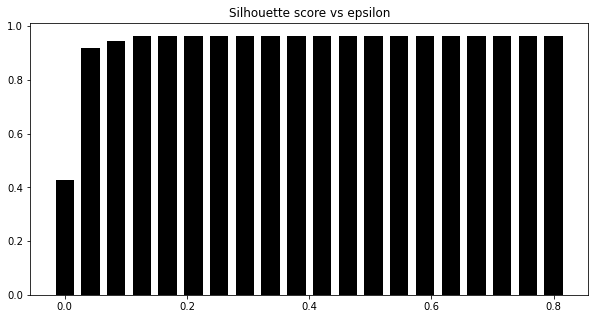

In [56]:
# Plot silhouette scores vs epsilon
plt.figure(5, figsize=(10,5))
plt.bar(eps_grid, silhouette_scores, width=0.03, color='k',align='center')
plt.title('Silhouette score vs epsilon');


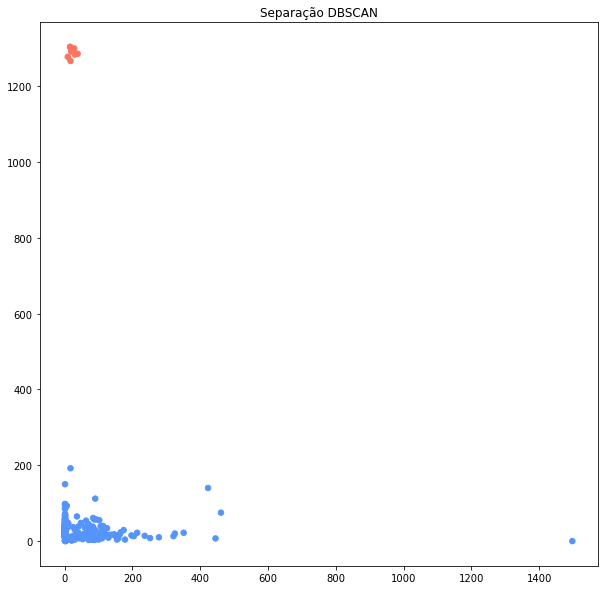

In [57]:
dbsdata = data_norm.copy()

db = DBSCAN(eps=eps_best, min_samples=5).fit(dbsdata)

colormap=np.array(['#5595FA','#FA7461','#9443A8', '#FAB72F', '#3CFA9F'])
vectorizer = np.vectorize(lambda x: colormap[x % len(colormap)])

plt.figure(6, figsize=(10,10))
#plt.scatter(dbsdata['Quantidade'], dbsdata['TempoMedio'], c=vectorizer(db.labels_), s=20)
plt.scatter(data['Quantidade'], data['TempoMedio'], c=vectorizer(db.labels_), s=30)

plt.title('Separação DBSCAN')
plt.show();

In [58]:
# Comparando os clusters gerados com os dados originais 

data['kmeans'] = kmeans.labels_
data['dbscan'] = db.labels_


print(data[['Quantidade', 'TempoMedio', 'kmeans', 'dbscan']])

     Quantidade  TempoMedio  kmeans  dbscan
0          1498           0       3       0
1           461          75       4       0
2           445           7       4       0
3           423         140       4       0
4           351          22       4       0
..          ...         ...     ...     ...
597           1           1       2       0
598           1          16       2       0
599           1          12       2       0
600           1          46       2       0
601           1          49       2       0

[602 rows x 4 columns]


## a) O que representam os clusters gerados?

 O cluster com a label 1 (para ambos os métodos) resultou num cluster que separa os acessos da "Equipe Daxia", que se distingue dos demais por possuir uma pequena quantidade de acessos por usuário, mas com um longo tempo de acesso.  
 O médodo DBSCAN separou em apenas dois clusters, com isso todas as demais linhas foram classificadas com a label 0 (o metodo não deixou de classificar nenhum ponto neste caso).  
 Para o método K-Means, o cluster com a label 0, agrupa a maior parte das observações, possuem baixos valores de quantidade e tempo médio de acesso.   
 Para o método K-Means, o cluster com a label 2, é formado apenas pelo acesso da "Equipe Dados Pesquisa" que possui uma enorme quantidade de acessos.  
 Para o método K-Means, o cluster com a label 3, é o segundo maior cluster encontrado, representa os usuários com uma quantidade intermediária de acessos (maiores que o cluster 0 e menores que o clusiter 4).  
 Para o método K-Means, o cluster com a label 4, representa os usuários com alta quantidade de acessos.  

## b) Qual é a melhor quantidade de Clusters?

 Segundo o médodo do "joelho" utilizado no método K-Means a quantidade adequada encontrada se situa entre 4 e 5 clusters.  
 Quando observamos pelo Silhouette scores do método DBSCAN encontramos a quantidade adequada de exatamente 2 clusters.  
 O grupo acreddita que pelo que poodemos observar dos dados, a quantidade de clusters no caso do K-Means é a mais adequada, pois possuimos ainda uma grande diferença entre os usuários observados no cluster com a label 0 do método DBSCAN.

## c) Qual é a melhor técnica (k-means ou DBSCAN) a ser utilizada nessa clusterização?  

 Conforme apontado na questão anterior, a clusterização encotrada pelo método DBSCAN manteve um cluster com a maior parte dos usuários observados, mesmo estes apresentando grande diferença entre eles. Portanto para este conjunto de dados acreditamos que o método K-means obteve um resultado melhor.